# Reverse Engineering JPL Horizons Refraction

### Don Cross 2019-04-13

I have discovered that NOVAS C 3.1 does not model atmospheric refraction the same way as JPL Horizons for objects that are more than one degree below the horizon. In some ways this does not matter because such objects are not visible to a topocentric observer.

However, this discrepancy does cause a couple of issues for this project:

- It makes it harder to unit test by comparing horizontal coordinates from NOVAS C 3.1 and JPL Horizons.

- The NOVAS formula for refraction has a step discontinuity when the zenith angle exceeds 91 degrees. This may cause algorithmic problems trying to calculate rise and set times.

Therefore, I want to study the JPL Horizons refraction calculation. I do not have source code or even a good description of its behavior for objects below the horizon, but I suspect they were also concerned about calculating rise and set times. If so, I would like to create a compatible refraction algorithm.

I will compare altitude values from two different JPL Horizons runs of the same body, one with atmospheric refraction, the other without.

In [62]:
import re
from matplotlib import pyplot as plt
import numpy as np
import math

def LoadAltitudeData(filename):
    with open(filename, 'rt') as infile:
        data = []
        for line in infile:
            m = re.match(r'^\s(\d{4})-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-(\d{2})\s(\d{2}):(\d{2})\s[\* ACN][ mrts]\s*(\d+\.\d+)\s+(-?\d+\.\d+)\s+(\d+\.\d+)\s+(-?\d+\.\d+)\s+(\d+\.\d+)\s+(-?\d+\.\d+)', line)
            if m:
                altitude = float(m.group(11))
                data.append(altitude)
        return np.array(data)

refract = LoadAltitudeData('../horizons/Sun_equinox.txt')
airless = LoadAltitudeData('../horizons/airless_Sun_equinox.txt')
print('len(refract) =', len(refract))
print('len(airless) =', len(refract))

len(refract) = 2881
len(airless) = 2881


Subtract the airless altitudes from the refracted altitudes to get the refraction correction.

In [63]:
correction = refract - airless
print(max(correction))
print(len(correction))

0.6467000000000098
2881


Text(0, 0.5, 'Refraction angle [degrees]')

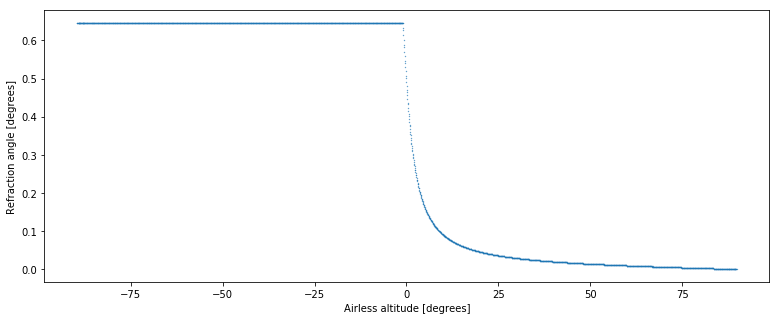

In [64]:
plt.figure(figsize=(13,5))
plt.scatter(airless, correction, s=0.1)
plt.xlabel('Airless altitude [degrees]')
plt.ylabel('Refraction angle [degrees]')

JPL Horizons clamps the maximum refraction angle to 0.6467 degrees. Do they ever report an angle beyond -90 degrees?

In [65]:
print(min(airless))
print(min(refract))
print(min(refract) - min(airless))

-89.6335
-88.9869
0.6465999999999923


Text(0, 0.5, 'Refraction [degrees]')

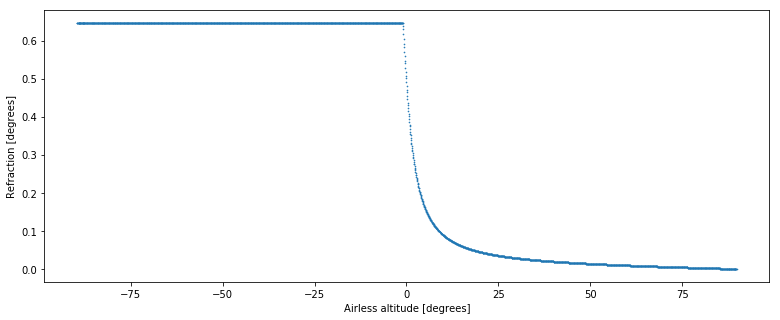

In [66]:
DEG2RAD = 0.017453292519943296
clamp = 0.6467

def refract(zd_obs, height):
    if zd_obs < 0.1:
        return 0.0
    if zd_obs > 91.0:
        return clamp
    pressure = 1010 * math.exp(-height / 9100)
    celsius = 10
    kelvin = 273 + celsius
    h = 90 - zd_obs
    angle = (h + 7.31/(h + 4.4))
    r = 0.016667 / math.tan(angle * DEG2RAD)
    refr = r * (0.28 * pressure / kelvin);
    return min(clamp, refr)

def refract_iter(zd, height):
    zd0 = zd
    while True:
        zd1 = zd
        refr = refract(zd, height)
        zd = zd0 - refr
        if abs(zd - zd1) <= 3.0e-5:
            return refr

calc_correction = np.array([refract_iter(90-a, 0) for a in airless])
plt.figure(figsize=(13,5))
plt.scatter(airless, calc_correction, s=0.4)
plt.xlabel('Airless altitude [degrees]')
plt.ylabel('Refraction [degrees]')

Text(0, 0.5, 'Discrepancy [degrees]')

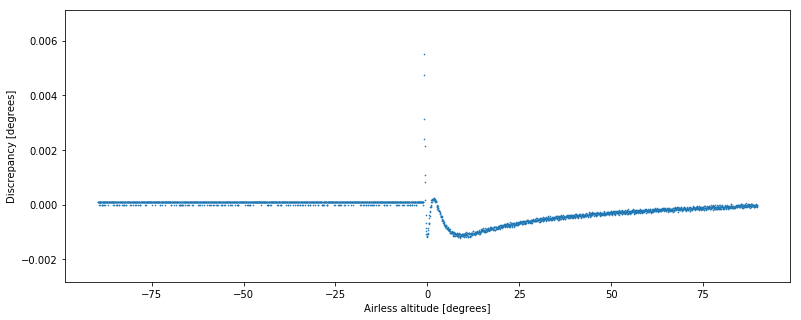

In [67]:
plt.figure(figsize=(13,5))
discrepancy = calc_correction - correction
plt.scatter(airless, discrepancy, s=0.4)
plt.xlabel('Airless altitude [degrees]')
plt.ylabel('Discrepancy [degrees]')

I found the following document:

http://extras.springer.com/1999/978-1-4471-0555-8/chap4/horizons/horizons.pdf

It says: 

Refraction computation is based on [6-7]:
6. Saemundsson, T., Sky & Telescope, July, 1986, p.70.
7. Meeus, J., "Astronomical Algorithms", 1991, p. 101-102

The following purports to be an implementation of the Meeus algorithm:
https://github.com/soniakeys/meeus/blob/master/v3/refraction/refract.go

My guess is it is the Saemundsson function I want. Here is a Python version:


sae range: max= 0.7441034274697825 , min= -0.08334343987855958


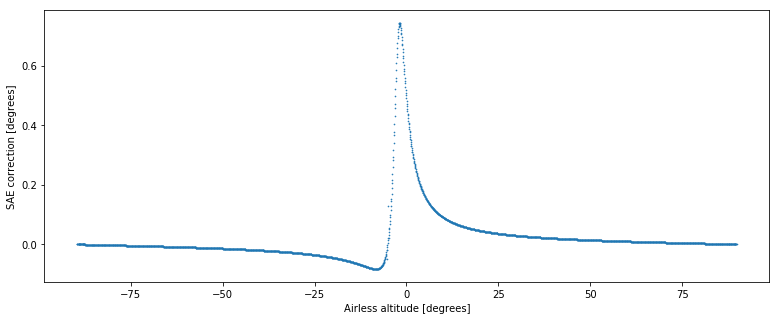

In [68]:
def refract_sae(zd_obs):
    hd = 90 - zd_obs
    return (1.02 / math.tan((hd+10.3/(hd+5.11))*DEG2RAD)) / 60

sae_correction = np.array([refract_sae(90-a) for a in airless])

plt.figure(figsize=(13,5))
plt.scatter(airless, sae_correction, s=0.4)
plt.xlabel('Airless altitude [degrees]')
plt.ylabel('SAE correction [degrees]')

print('sae range: max=', max(sae_correction), ', min=', min(sae_correction))

Text(0, 0.5, 'SAE correction [degrees]')

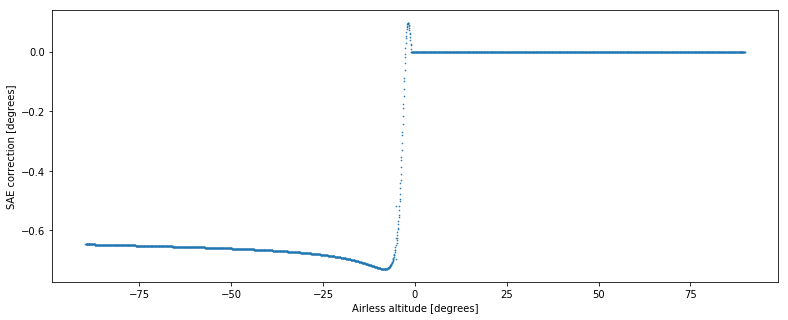

In [69]:
plt.figure(figsize=(13,5))
discrepancy = sae_correction - correction
plt.scatter(airless, discrepancy, s=0.4)
plt.xlabel('Airless altitude [degrees]')
plt.ylabel('SAE correction [degrees]')

In [70]:
print(refract_sae(91))

0.6465806208810249


OK, that is exciting because it matches exactly for all the positive airless altitudes, and the cutoff at zenith angle = 91 degrees matches the value I found in the JPL Horizons data. So apparently they are using SAE with no iteration, and clamping for any angle below -1 degrees.

I think I need to allow the caller to specify different refraction algorithms so that I can unit test against both the NOVAS formula and the JPL Horizons formula.

Trying again with modified SAE: clamp angles to -1 below the horizon.

max= 0.6465806208810249 , min= 2.5630064829801765e-05


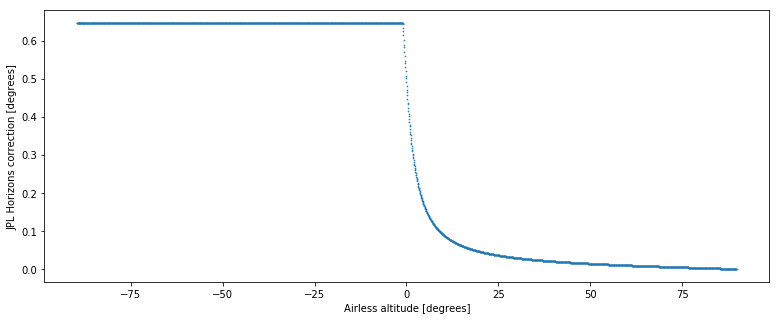

In [71]:
def refract_jplhor(zd_obs):
    hd = max(-1, 90 - zd_obs)
    return (1.02 / math.tan((hd+10.3/(hd+5.11))*DEG2RAD)) / 60

jplhor_correction = np.array([refract_jplhor(90-a) for a in airless])

plt.figure(figsize=(13,5))
plt.scatter(airless, jplhor_correction, s=0.4)
plt.xlabel('Airless altitude [degrees]')
plt.ylabel('JPL Horizons correction [degrees]')

print('max=', max(jplhor_correction), ', min=', min(jplhor_correction))

Text(0, 0.5, 'Discrepancy [degrees]')

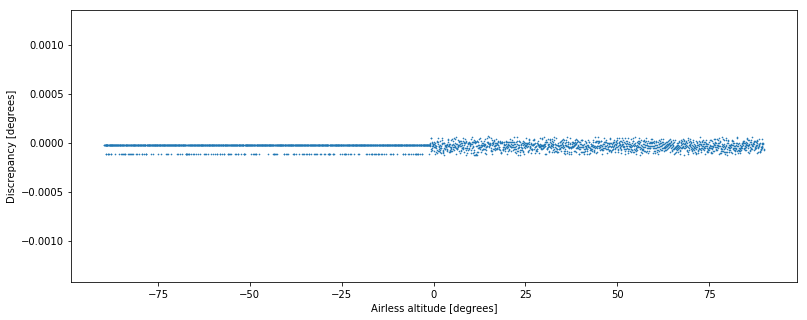

In [72]:
plt.figure(figsize=(13,5))
discrepancy = jplhor_correction - correction
plt.scatter(airless, discrepancy, s=0.4)
plt.xlabel('Airless altitude [degrees]')
plt.ylabel('Discrepancy [degrees]')

That's it! The small amount of noise I believe is due to the limited decimal precision of the JPL Horizons text files I processed: I am subtracted two angles that each look something like -51.9056, with 4 places after the decimal.